In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle5 as pickle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.mixture import GaussianMixture as GMM
from transformer import DataTransformer

from geo_handler import (geo_loc, get_lat_long, take_closest, 
                         get_octa, reorganize_geocodes, get_nearest_loc,
                         augment_geocode_dict)

In [65]:
ADD_GEO_MAP = pickle.load(open('models/add_to_geo_map.pkl', 'rb'))
FOREX = pickle.load(open("models/exchange_rates.pkl", "rb"))

In [66]:
from bisect import bisect_left
from geopy.distance import geodesic
from collections import OrderedDict
from operator import getitem
import numpy as np


def geo_loc(point = None, address = None):
    
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="map.app")
    
    if address is None:
        try:
            location = geolocator.reverse(point)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid geo-coordinates !!'
    else:
        try:
            location = geolocator.geocode(address)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid Address !!'

def get_lat_long(address):
    try:
        point_ = ADD_GEO_MAP[address.strip()]
        return point_['latitude'], point_['longitude']
    except:
        point_ = geo_loc(address = address.strip())
        return point_[2]['lat'], point_[2]['lon']
    else:
        return 0, 0
    

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def get_octa(point):
    if float(point['latitude']) < 0:
        if float(point['longitude']) < 0:
            return int(float(point['longitude']) / -90)
        else:
            return int(float(point['longitude']) / 90) + 2
    else:
        if float(point['longitude']) < 0:
            return int(float(point['longitude']) / -90) + 4
        else:
            return int(float(point['longitude']) / 90) + 6


def reorganize_geocodes(geocodes_dictionary):
    from collections import OrderedDict
    coordinates = OrderedDict()
    
    coordinates['address'] = np.array(list(geocodes_dictionary.keys()))
    coordinates['latitude'] = np.array([row['latitude'] for name, row in geocodes_dictionary.items()])
    coordinates['longitude'] = np.array([row['longitude'] for name, row in geocodes_dictionary.items()])
    coordinates['category'] = np.array([row['category'] for name, row in geocodes_dictionary.items()])
    coordinates['distance'] = np.array([row['distance'] for name, row in geocodes_dictionary.items()])
    return coordinates

def augment_geocode_dict(geocodes):
    
    from geopy.distance import geodesic
    from collections import OrderedDict
    from operator import getitem
    
    for key in geocodes.keys():
        geocodes[key]['category'] = get_octa(geocodes[key])
        geocodes[key]['distance'] = float(geodesic((0, 0), (geocodes[key]['latitude'], geocodes[key]['longitude'])).km)
    geocodes = OrderedDict(sorted(geocodes.items(), key=lambda x: getitem(x[1], 'distance')))
    return geocodes


def get_nearest_loc(point, geocodes = None):
    from geopy.distance import geodesic
    if geocodes is None:
        return geo_loc(point)
    else:
        point_category = get_octa(point)
        geolist = geocodes['distance'][geocodes['category'] == point_category]
        distance = float(geodesic((0, 0), (point['latitude'], point['longitude'])).km)
        closest = np.where(geocodes['distance'] == take_closest(geolist, distance))
        
        closest_category = geocodes['category'][closest][0]
        closest_distance = geocodes['distance'][closest][0]
        # print(closest_category, point_category, abs(closest_distance - distance))
        if (closest_category != point_category) or abs(closest_distance - distance) > 10:
            return geo_loc(point)
        else:
            # return point_category, closest_category, distance, closest_distance, geocodes['address'][closest[0][0]]
            return geocodes['address'][closest[0][0]]

In [67]:
# %time
# COORDS = reorganize_geocodes(augment_geocode_dict(ADD_GEO_MAP))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [5]:
df = pd.read_csv('data/hackathon_parsed_format_a.csv')

In [6]:
%%time
df[['59f_ben_add_lat', '59f_ben_add_lon']][:100] \
                .apply(lambda x: 
                    get_nearest_loc({'latitude' : x[0], 'longitude': x[1]}, 
                                    geocodes = COORDS), axis = 1)

NameError: name 'COORDS' is not defined

In [7]:
df.head()

,32a_val_dt,33b_cur,33b_orig_ord_amt,50a_payor_lon,50a_payor_lat,50f_payor_acct_nm:,50f_payor_name:,50f_payor_add_ln_1,50f_payor_add_ln_2,50f_payor_add_lat,...,50k_payor_add_lon,59f_ben_acct_num:,59f_ben_name,59f_ben_add_ln_1,59f_ben_add_ln_2,59f_ben_add_lat,59f_ben_add_lon,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,2021-08-13,RUB,1544103.68,/0000000000000000000000000000009621,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,6099,ANGEL JAMES,1789 PHILLIPS RD,US GLENDALE,34.146942,-118.247847,SHA,NaN,NaN
1,2021-08-13,RUB,912070.95,/0000000000000000000000000000007346,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,874,JAKUB EVANS,369653 PEAR ST,US WELLS,47.566422,-99.650882,BEN,RUB,0.0
2,2021-08-13,RUB,21760302.59,/0000000000000000000000000000005305,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,5436,ZIGA MITCHELL,131041 DEBRA DR,US GROVER,42.795605,-110.929451,SHA,NaN,NaN
3,2021-08-13,RUB,878587.53,/0000000000000000000000000000004127,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,8707,YAEL DEMERS,50438 HAYMARKET ST,US MOORE,35.815612,-101.910435,SHA,NaN,NaN
4,2021-08-13,RUB,6696355.97,/0000000000000000000000000000006978,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,4326,NOEL PLANTE,43790 MOSHER CT,US WAUCHULA,27.547259,-81.811471,SHA,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f888d025f10>,
      dtype=object)

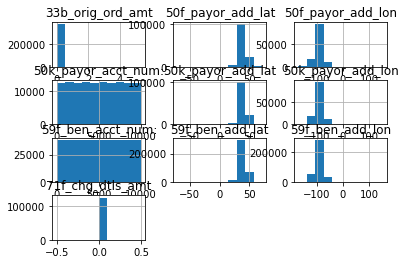

In [8]:
df.hist()

In [9]:
data = pd.DataFrame()

In [10]:
data = df[['33b_cur', '33b_orig_ord_amt']]

In [11]:
%%time
conditions = [
    ~df['50a_payor_lon'].isnull(), 
    ~df['50f_payor_add_ln_2'].isnull(), 
    ~df['50k_payor_add_ln_2'].isnull()]
choices = ['A', 'F', 'K']
data['src_xfrr_type'] = np.select(conditions, choices, default = "")

CPU times: user 49.6 ms, sys: 3.51 ms, total: 53.1 ms
Wall time: 52.6 ms


In [12]:
%%time
conditions = [
    df['50f_payor_add_lon'] != "",
    df["50k_payor_add_lon"] != ""]
choices = [df["50f_payor_add_lon"], df["50k_payor_add_lon"]]
data['src_lon'] = np.select(conditions, choices, default=0)

CPU times: user 5.85 ms, sys: 393 µs, total: 6.24 ms
Wall time: 5.58 ms


In [13]:
%%time
conditions = [
    df["50f_payor_add_lat"] != "",
    df["50k_payor_add_lat"] != ""]
choices = [df["50f_payor_add_lat"], df["50k_payor_add_lat"]]
data["src_lat"] = np.select(conditions, choices, default=0)

CPU times: user 4.6 ms, sys: 128 µs, total: 4.73 ms
Wall time: 4.12 ms


In [14]:
data[["target_lat", "target_lon"]] = df.loc[:, ["59f_ben_add_lat", "59f_ben_add_lon"]]

In [15]:
data["charge_dtls"] = df.loc[:, "71A_chg_dtls"]

In [16]:
data[["charge_dtls_cur", "charge_dtls_amt"]] = df.loc[:, ["71f_chg_dtls_cur", "71f_chg_dtls_amt"]]

In [17]:
data

,33b_cur,33b_orig_ord_amt,src_xfrr_type,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,1544103.68,A,NaN,NaN,34.146942,-118.247847,SHA,NaN,NaN
1,RUB,912070.95,A,NaN,NaN,47.566422,-99.650882,BEN,RUB,0.0
2,RUB,21760302.59,A,NaN,NaN,42.795605,-110.929451,SHA,NaN,NaN
3,RUB,878587.53,A,NaN,NaN,35.815612,-101.910435,SHA,NaN,NaN
4,RUB,6696355.97,A,NaN,NaN,27.547259,-81.811471,SHA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
379521,USD,8339.00,A,NaN,NaN,37.653540,-122.416866,SHA,NaN,NaN
379522,USD,4001.56,F,-96.707775,40.808886,39.793896,-74.223206,BEN,USD,0.0
379523,USD,4456.00,F,-81.822065,37.941215,39.808320,-104.933868,OUR,NaN,NaN
379524,USD,8836.10,A,NaN,NaN,40.366432,-105.502855,SHA,NaN,NaN


In [18]:
data["charge_dtls_cur"] = data["charge_dtls_cur"].replace(np.nan, "999", regex=True)
data["charge_dtls_amt"] = data["charge_dtls_amt"].replace(np.nan, 0, regex=True)

data["target_lat"] = data["target_lat"].replace(np.nan, 0, regex=True)
data["target_lon"] = data["target_lon"].replace(np.nan, 0, regex=True)
data["src_lon"] = data["src_lon"].replace(np.nan, 0, regex=True)
data["src_lat"] = data["src_lat"].replace(np.nan, 0, regex=True)

In [19]:
data.columns

Index(['33b_cur', '33b_orig_ord_amt', 'src_xfrr_type', 'src_lon', 'src_lat',
       'target_lat', 'target_lon', 'charge_dtls', 'charge_dtls_cur',
       'charge_dtls_amt'],
      dtype='object')

In [20]:
data

,33b_cur,33b_orig_ord_amt,src_xfrr_type,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,1544103.68,A,0.000000,0.000000,34.146942,-118.247847,SHA,999,0.0
1,RUB,912070.95,A,0.000000,0.000000,47.566422,-99.650882,BEN,RUB,0.0
2,RUB,21760302.59,A,0.000000,0.000000,42.795605,-110.929451,SHA,999,0.0
3,RUB,878587.53,A,0.000000,0.000000,35.815612,-101.910435,SHA,999,0.0
4,RUB,6696355.97,A,0.000000,0.000000,27.547259,-81.811471,SHA,999,0.0
...,...,...,...,...,...,...,...,...,...,...
379521,USD,8339.00,A,0.000000,0.000000,37.653540,-122.416866,SHA,999,0.0
379522,USD,4001.56,F,-96.707775,40.808886,39.793896,-74.223206,BEN,USD,0.0
379523,USD,4456.00,F,-81.822065,37.941215,39.808320,-104.933868,OUR,999,0.0
379524,USD,8836.10,A,0.000000,0.000000,40.366432,-105.502855,SHA,999,0.0


In [21]:
numerical_columns = data._get_numeric_data().columns
discrete_columns = [col for col in data.columns if col not in numerical_columns]

In [22]:
def generate(dataframe, num_samples=1000, n_components = 10):
    numerical_columns = dataframe._get_numeric_data().columns
    discrete_columns = [col for col in dataframe.columns if col not in numerical_columns]
    
    _transformer = DataTransformer()
    _transformer.fit(dataframe, discrete_columns)
    data = _transformer.transform(dataframe)
    gmm = GMM(n_components = n_components, covariance_type = "full", random_state = 0).fit(data)
    Xnew = gmm.sample(num_samples)
    Xnew_inv = _transformer.inverse_transform(Xnew[0])
    Xnew_inv["label"] = Xnew[1]
    return gmm, _transformer, Xnew_inv

In [23]:
# %%time
# model, transformer, samples = generate(data, num_samples = 1000)

In [24]:
%%time
model = pickle.load(open('models/GMM_MODEL.pkl', 'rb'))
transformer = pickle.load(open('models/GMM_TRANSFORMER.pkl', 'rb'))

CPU times: user 0 ns, sys: 2.95 ms, total: 2.95 ms
Wall time: 2.41 ms


In [25]:
samples = transformer.inverse_transform(model.sample(10000)[0])

In [26]:
samples

,33b_cur,33b_orig_ord_amt,src_xfrr_type,src_lon,src_lat,target_lat,target_lon,charge_dtls,charge_dtls_cur,charge_dtls_amt
0,RUB,2.064478e+06,A,-0.000132,0.000265,36.274950,-90.074791,SHA,999,-1.072012e-06
1,RUB,2.820583e+06,A,0.000517,0.000071,35.087264,-83.228879,OUR,999,-9.516857e-07
2,RUB,2.270811e+06,A,0.000213,0.000580,40.033478,-86.404609,OUR,999,-1.763688e-06
3,RUB,1.275147e+06,K,-0.000072,-0.000057,42.599156,-97.472672,SHA,999,-2.024139e-07
4,RUB,4.823692e+06,A,-0.000461,0.000328,41.152259,-94.448241,SHA,999,2.359516e-06
...,...,...,...,...,...,...,...,...,...,...
9995,GBP,5.960581e+06,A,-0.000027,-0.000032,36.845597,-89.540409,SHA,999,-1.670894e-06
9996,RUB,8.892355e+06,A,0.000496,0.000039,38.365652,-88.355617,SHA,999,-3.246424e-06
9997,GBP,8.582899e+04,A,-0.000198,-0.000218,34.795048,-84.171482,SHA,999,3.653687e-06
9998,RUB,1.193596e+06,A,-0.000350,0.000021,41.982602,-122.390249,SHA,999,-2.503724e-06


In [27]:
def corrplot(data, samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(data.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")
    
    plt.subplot(122)
    sns.heatmap(samples.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")

In [28]:
def attr_plot(data, samples):
    for col in data.columns:
        if col not in discrete_columns:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.distplot(data[col], bins=100, hist_kws={'alpha': 0.7})
            plt.subplot(122)
            sns.distplot(samples[col], bins=100, hist_kws={'alpha': 0.7})
        else:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.countplot(x=col, data=data)
            plt.xticks(rotation=45)
            plt.subplot(122)
            sns.countplot(x=col, data=samples)
            plt.xticks(rotation=45)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


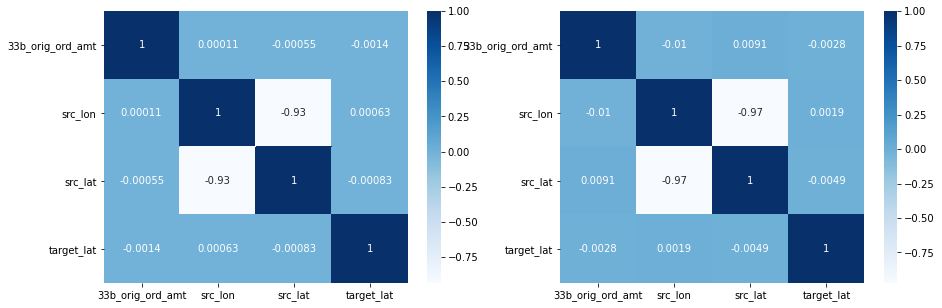

In [29]:
%time
corrplot(data, samples)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.48 µs


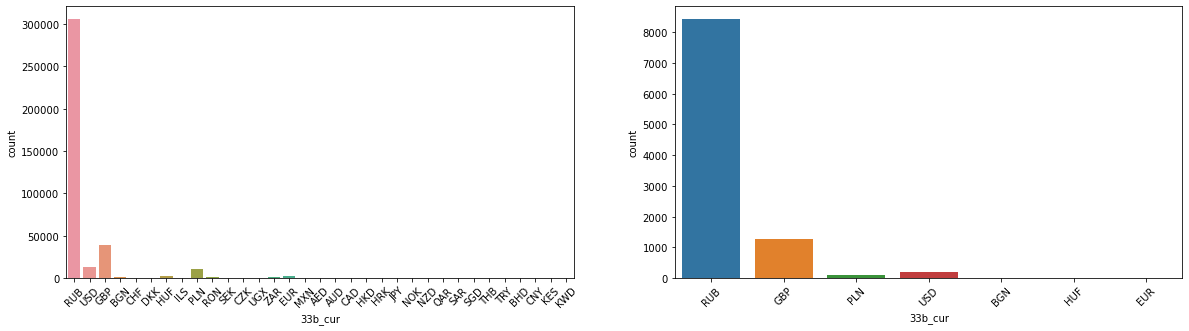

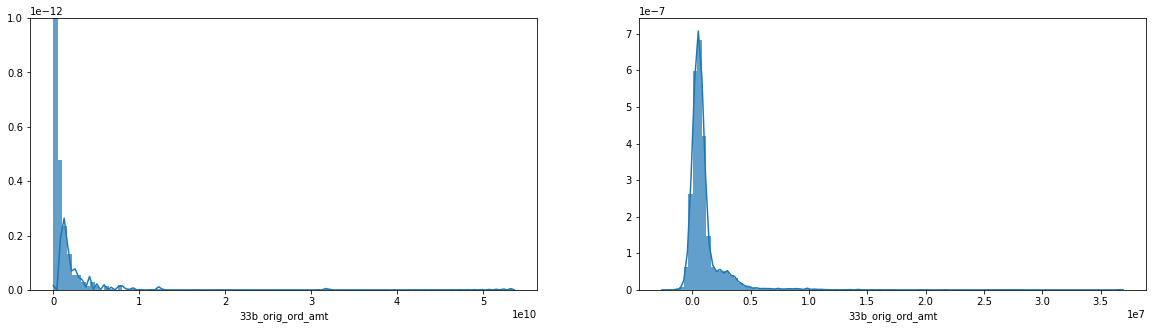

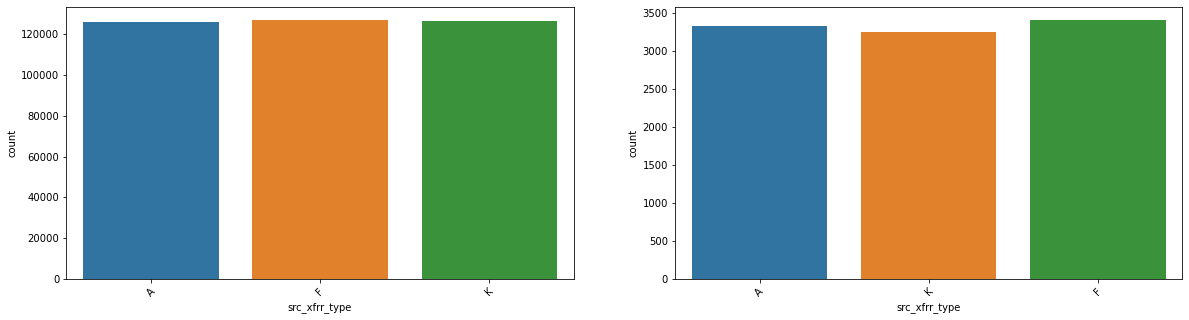

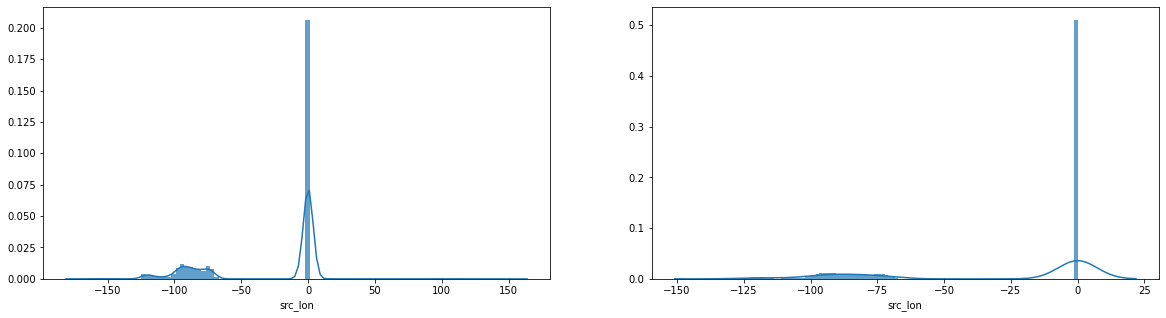

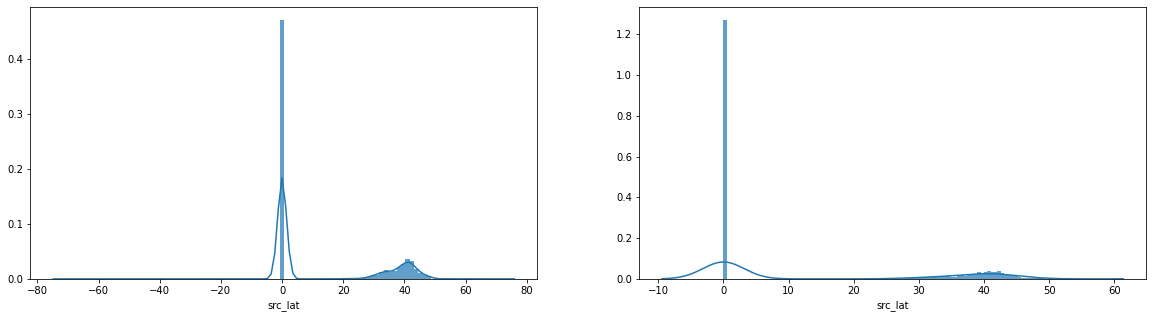

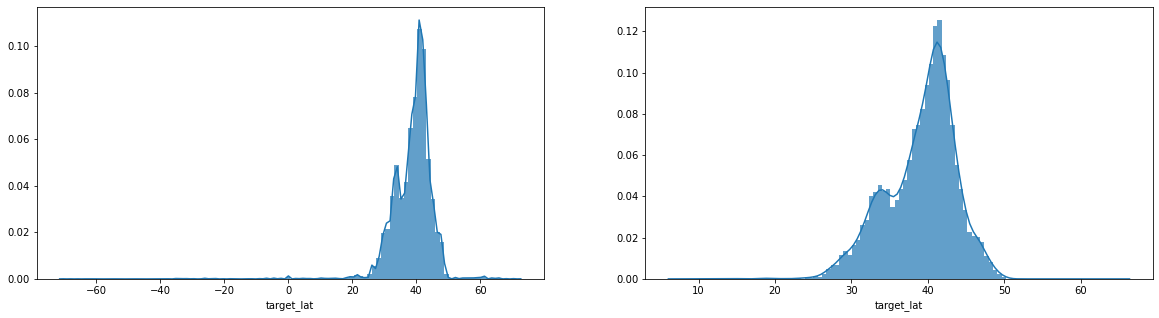

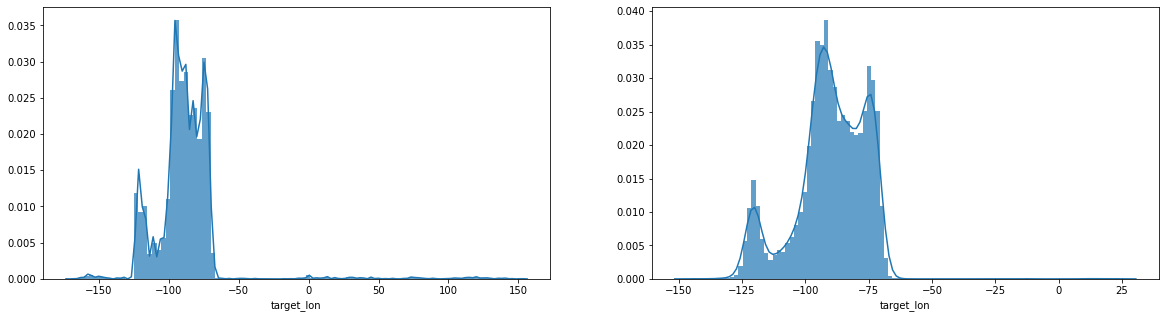

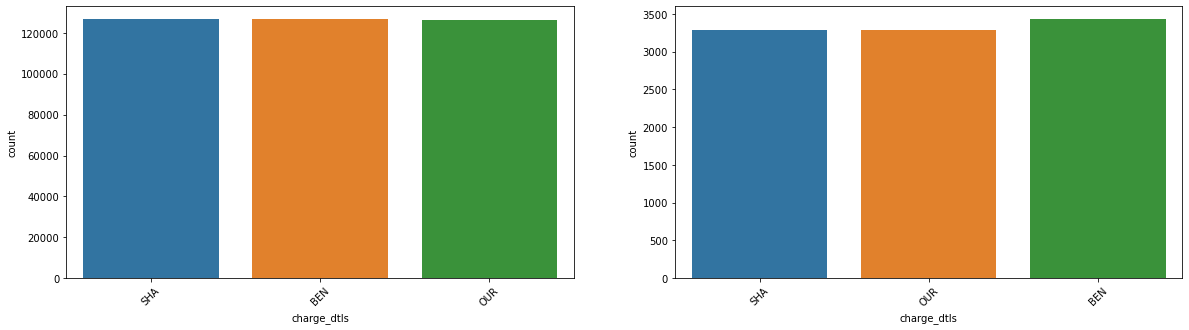

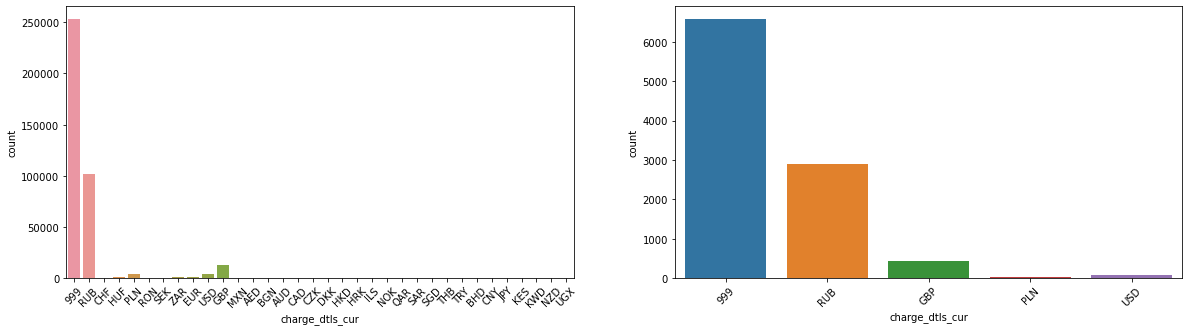

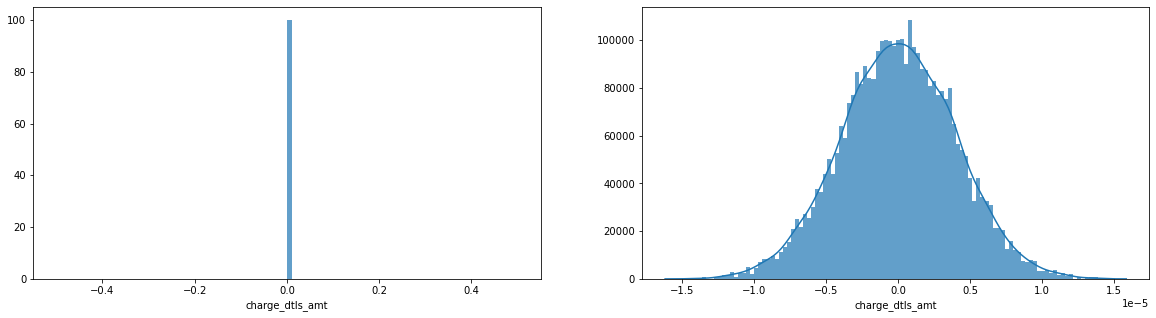

In [30]:
%time
attr_plot(data, samples)

In [31]:
# pickle.dump(model, open('models/GMM_MODEL.pkl', 'wb'))

In [32]:
# pickle.dump(transformer, open('models/GMM_TRANSFORMER.pkl', 'wb'))

In [33]:
samples.columns

Index(['33b_cur', '33b_orig_ord_amt', 'src_xfrr_type', 'src_lon', 'src_lat',
       'target_lat', 'target_lon', 'charge_dtls', 'charge_dtls_cur',
       'charge_dtls_amt'],
      dtype='object')

In [34]:
df.columns

Index(['32a_val_dt', '33b_cur', '33b_orig_ord_amt', '50a_payor_lon',
       '50a_payor_lat', '50f_payor_acct_nm:', '50f_payor_name:',
       '50f_payor_add_ln_1', '50f_payor_add_ln_2', '50f_payor_add_lat',
       '50f_payor_add_lon', '50k_payor_acct_num:', '50k_payor_name',
       '50k_payor_add_ln_1', '50k_payor_add_ln_2', '50k_payor_add_lat',
       '50k_payor_add_lon', '59f_ben_acct_num:', '59f_ben_name',
       '59f_ben_add_ln_1', '59f_ben_add_ln_2', '59f_ben_add_lat',
       '59f_ben_add_lon', '71A_chg_dtls', '71f_chg_dtls_cur',
       '71f_chg_dtls_amt'],
      dtype='object')

In [35]:
samples[['src_lat', 'src_lon']][:10]

,src_lat,src_lon
0,0.000265,-1.324768e-04
1,0.000071,5.174235e-04
2,0.000580,2.126668e-04
3,-0.000057,-7.178267e-05
4,0.000328,-4.609805e-04
5,0.000144,-8.469102e-06
6,0.000021,8.203254e-07
7,0.000197,3.113992e-04
8,-0.000122,2.215716e-04
9,-0.000123,-9.809878e-06


In [78]:
def convert_b2a(dataframe, df):
    revert = pd.DataFrame()
    for col in df.columns:
        if col in dataframe.columns:
            revert[col] = dataframe[col]
    
#     condition = ['src_xfrr_type' == 'A', 
#                  'src_xfrr_type' == 'F', 
#                  'src_xfrr_type' == 'K']
#     choices = [dataframe['src_lon'], 0, 0]
#     revert['50a_payor_lon'] = np.select(condition, choices, default = 0) 
    revert['50a_payor_lon'] = ''
    revert['50a_payor_lat'] = ''
    revert['50f_payor_acct_nm:'] = ''
    revert['50f_payor_name:'] = ''
    revert['50f_payor_add_ln_1'] = ''
    revert['50f_payor_add_ln_2'] = dataframe[['src_xfrr_type', 'src_lat', 'src_lon']].apply(lambda x:
                                        get_nearest_loc({'latitude' : x[1], 'longitude': x[2]}, 
                                        geocodes = COORDS) if x[0] == 'F' else '', axis = 1)
    
    revert[['50f_payor_add_lat', '50f_payor_add_lon']] = samples[['src_xfrr_type', 'src_lat', 'src_lon']]\
                                            .apply(lambda x: pd.Series(([x[1], x[2]])
                                            if x[0] == 'F' else [''] * 2, index=['lat', 'lon']), axis = 1)
    # revert['50k_payor_acct_num:'] = 
    # revert['50k_payor_name'] =
    # revert['50k_payor_add_ln_1'] = 
    revert['50k_payor_add_ln_2'] = dataframe[['src_xfrr_type', 'src_lat', 'src_lon']].apply(lambda x:
                                        get_nearest_loc({'latitude' : x[1], 'longitude': x[2]}, 
                                        geocodes = COORDS) if x[0] == 'K' else '', axis = 1)
    revert[['50k_payor_add_lat', '50k_payor_add_lon']] = samples[['src_xfrr_type', 'src_lat', 'src_lon']].apply(lambda x: 
                                                            pd.Series(([x[1], x[2]])
                                                            if x[0] == 'F' else [''] * 2, index=['lat', 'lon']), axis = 1)
    # '59f_ben_acct_num:', 
    # '59f_ben_name',
    # '59f_ben_add_ln_1'
    revert['59f_ben_add_ln_2'] = dataframe[['target_lat', 'target_lon']].apply(lambda x: 
                                        get_nearest_loc({'latitude' : x[0], 'longitude': x[1]}, 
                                        geocodes = COORDS), axis = 1)
    revert['59f_ben_add_lat'] = samples['target_lat']
    revert['59f_ben_add_lon'] = samples['target_lon']
    revert['71A_chg_dtls'] = samples['charge_dtls']
    revert['71f_chg_dtls_cur'] = samples['charge_dtls_cur']
    revert['71f_chg_dtls_amt'] = samples['charge_dtls_amt']

    return revert

In [79]:
%%time
revert = convert_b2a(samples, df)

CPU times: user 11.4 s, sys: 11 ms, total: 11.4 s
Wall time: 11.4 s


In [80]:
revert

,33b_cur,33b_orig_ord_amt,50a_payor_lon,50a_payor_lat,50f_payor_acct_nm:,50f_payor_name:,50f_payor_add_ln_1,50f_payor_add_ln_2,50f_payor_add_lat,50f_payor_add_lon,50k_payor_add_ln_2,50k_payor_add_lat,50k_payor_add_lon,59f_ben_add_ln_2,59f_ben_add_lat,59f_ben_add_lon,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,RUB,2.064478e+06,,,,,,,,,,,,US THOMSON,36.274950,-90.074791,SHA,999,-1.072012e-06
1,RUB,2.820583e+06,,,,,,,,,,,,US MARINE CITY,35.087264,-83.228879,OUR,999,-9.516857e-07
2,RUB,2.270811e+06,,,,,,,,,,,,US PINSON,40.033478,-86.404609,OUR,999,-1.763688e-06
3,RUB,1.275147e+06,,,,,,,,,Invalid geo-coordinates !!,,,US LANGDON,42.599156,-97.472672,SHA,999,-2.024139e-07
4,RUB,4.823692e+06,,,,,,,,,,,,US HUBBARD,41.152259,-94.448241,SHA,999,2.359516e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,GBP,5.960581e+06,,,,,,,,,,,,US GERMANTOWN,36.845597,-89.540409,SHA,999,-1.670894e-06
9996,RUB,8.892355e+06,,,,,,,,,,,,US ELGIN,38.365652,-88.355617,SHA,999,-3.246424e-06
9997,GBP,8.582899e+04,,,,,,,,,,,,US PERRYSBURG,34.795048,-84.171482,SHA,999,3.653687e-06
9998,RUB,1.193596e+06,,,,,,,,,,,,US SHAFTER,41.982602,-122.390249,SHA,999,-2.503724e-06
